In [17]:
import numpy as np
import pandas as pd

from fenginering.function import *
from fenginering.indicator import *
from fenginering.transformer import *
from fenginering.preprocessing import Crossover
from fenginering.preprocessing import Scale

from data.get_data import *


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
start = "2019"
end = "2023"
data = get_data('BTC', '1h').loc[start : end]
data.drop(columns = ['symbol'], inplace = True)
data.columns = data.columns.astype(str)
data.shape

(37527, 5)

In [19]:
data['target'] = get_classification_target(data)
data = data.iloc[:-1]

## CrossMA

In [20]:
sma_list = [3, 7, 10, 14, 21, 28, 30, 40, 45, 60, 75, 80, 96]
#sma_list_h = range(3, 2, 200)

cross = Crossover(data)
features = cross.ma(sma, sma_list)

In [21]:
lag_ret_list = [1, 3, 5, 9, 15, 30]
ema_list = [3, 9, 15]
rsi_list = [10, 14, 20]

atr_list = [10, 20, 25, 30, 48, 72]

macd_dict = {
    'slow' : [10, 14],
    'fast' : [3, 5],
    'signal' : [2, 3]
}

sar_dict = {
    'step' : [0.2],
    'max_step' : [0.2]
}

stochastic_oscillator_dict = {
    'k_period' : [10, 15, 20],
    'd_period' : [3, 5]
}

Indicators = MakeIndicator(data)
Indicators.set_stransformer(lag_returns, lag_ret_list)
Indicators.set_stransformer(ema, ema_list)
Indicators.set_stransformer(rsi, rsi_list)
#Indicators.set_mtransformer(macd, macd_dict)
#Indicators.set_mtransformer(sar, sar_dict)
Indicators.set_mtransformer(stochastic_oscillator, stochastic_oscillator_dict)

Indicators.set_stransformer(atr, atr_list)

data_i = Indicators.get_data()

In [22]:

data = data_i.join(features)
data.dropna(inplace=True)

norm_scale = Scale(data)
data = norm_scale.transform()

<AxesSubplot: >

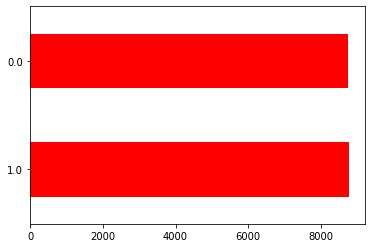

In [23]:
N = data.shape[0]
n = int(0.7*N)
train = data.loc["2021":"2022"]
test = data.loc["2023"]

features, target = train.drop(columns = ['target']), train['target']
features_test, target_test = test.drop(columns = ['target']), test['target']


target.value_counts().plot(kind = 'barh', color = 'red')

# PCA

In [24]:
import plotly.express as px
import plotly.graph_objects as go

In [25]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

X = data.drop(columns= "target")

scale = StandardScaler()

var = 0.95
pca = PCA(n_components=20)

# Manifold

# Model

In [26]:
from model import *

scale.fit(features)
Xe = scale.transform(features)

pca.fit(Xe)
features = pca.transform(Xe)

fig = go.Figure()
fig.add_trace(
    go.Bar(
        x = np.arange(1, len(pca.explained_variance_)+1),
        y = pca.explained_variance_ratio_
    )
)

fig.add_trace(
    go.Scatter(
        x = np.arange(1, len(pca.explained_variance_)+1),
        y = pca.explained_variance_ratio_.cumsum(),
        yaxis='y1'
    )
)

fig.show()

In [27]:

Xe_test = scale.transform(features_test)
features_test = pca.transform(Xe_test)

Models = fit(models, features, target, features_test, target_test)

LogisticRegression
 Accuracy : 0.55 
 f1 : 0.52 
 precision : 0.58 
 recall : 0.48 
 AUC : 0.57 
    -      -    -
    -      -    -
RandomForestClassifier
 Accuracy : 0.51 
 f1 : 0.47 
 precision : 0.54 
 recall : 0.42 
 AUC : 0.53 
    -      -    -
    -      -    -
XGBClassifier
 Accuracy : 0.51 
 f1 : 0.49 
 precision : 0.53 
 recall : 0.46 
 AUC : 0.52 
    -      -    -
    -      -    -


In [29]:
px.box(pd.DataFrame(Models))

In [30]:
from sklearn.ensemble import VotingClassifier

model = VotingClassifier(estimators = models, voting = 'soft')
model.fit(features, target)

VotingClassifier(estimators=[('LogisticRegression', LogisticRegression()),
                             ('RandomForestClassifier',
                              RandomForestClassifier()),
                             ('XGBClassifier',
                              XGBClassifier(base_score=0.5, booster='gbtree',
                                            callbacks=None, colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None, gamma=0,
                                            gpu_id=-1, grow_policy='depthwise',
                                            importance_type=None,
                                            interaction_constraints='',
                                            learning_rate=0.300000012,
                                            max_bin=256, max_cat_to_onehot=4,
                                            max_delta_step=0, max_depth=6,
                                            max_leaves=0, min_child_weight=1,
                                            missing=nan,
                                            monotone_constraints='()',
                                            n_estimators=100, n_jobs=0,
                                            num_parallel_tree=1,
                                            predictor='auto', random_state=0,
                                            reg_alpha=0, reg_lambda=1, ...))],
                 voting='soft')

 Accuracy : 0.52 
 f1 : 0.49 
 precision : 0.54 
 recall : 0.45 
 AUC : 0.54 
              precision    recall  f1-score   support

         0.0       0.50      0.58      0.54      1210
         1.0       0.54      0.45      0.49      1311

    accuracy                           0.52      2521
   macro avg       0.52      0.52      0.51      2521
weighted avg       0.52      0.52      0.51      2521



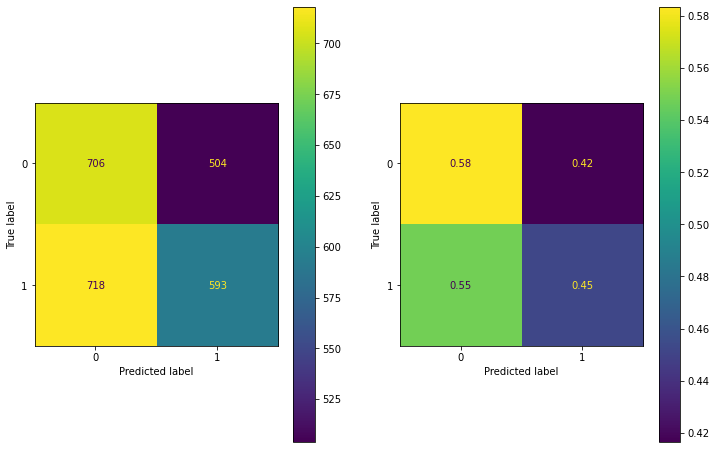

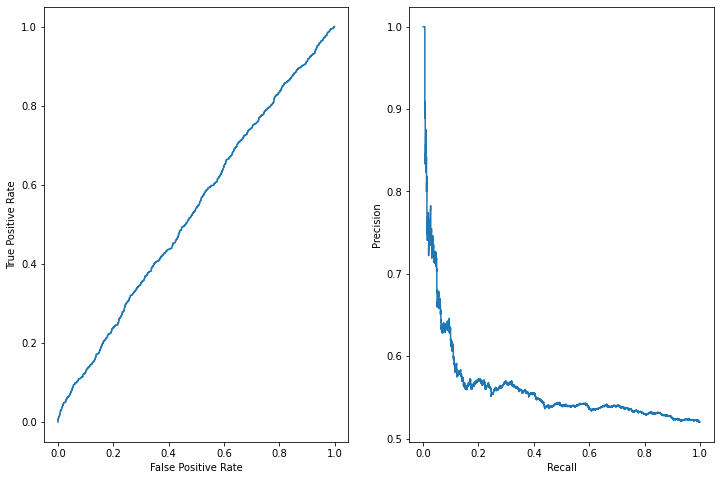

In [31]:
y_pred = model.predict(features_test)
y_pred_proba = model.predict_proba(features_test)

from evaluation.classification import *

evaluation = Evaluation(y_true = target_test, y_pred = y_pred, proba_pred = y_pred_proba[:,1])
evaluation.metrics()
evaluation.show()